In [355]:
import networkx as nx
import numpy as np
import json
from networkx.algorithms import community
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from src.helper import draw_spring, load_graph_from_json, score_normalize, dataframe_from_results, score_normalize
np.random.seed(123)
#pd.set_option("display.precision", 3)
pd.options.display.float_format = '{:20,.3f}'.format

# 3 Network Centrality

As already noted in Chapter 1, we can be interested in determining which nodes of a network are more important, more popular, or better connected. For instance, in the drone legislation example, we might be interested to measure which laws are frequently cited or citing other laws. Network centrality measures aim to retrieve this information. 

There are a variety of network centrality measures, and although they often overlap, they capture different ways in which a node may be regarded as central. Which centrality measure to use, depends on the research question one is interested in, domain knowledge, and sensitivity to context. When finding relevant drone laws, the direction of the citatations from one law to another may not matter so much, whereas in a network of case law this will be essential. 

The presentation that follows will show various centrality measures ranging from some very intuitive ones like degree centrality, to some more complex measures like Pagerank and HITS. The mathematics involved in the measures can become complicated for readers with a background in the humanities. Fortunately, the computer will take care of some otherwise intractable calculations allowing us to focus on the concepts. 

Note that it can be difficult to compare the scores of different centrality measures unless they are 'normalized' first. Normalization refers to making the measures insensitive to the number of nodes in a network and also putting the results in the same scale, for example from 0 to 1. Absent such procedure, it cannot be assumed that a score of 0.26 in one measure reflects greater centrality than a score of 0.14 in another measure. Normalizaiton makes comparisions possible. In addition to this, some measures are unintelligible without normalization. We refer to Appendix 3 for more information on normalization.

### 3.1 Degree and Degree Centrality

A first approach to finding which nodes are central relies on degree. Degree is a property of nodes that records how many neighbors a node is connected to (with edges). When using Degree, one defines nodes to be more central when they have a higher degree value than other nodes. It is possible to calculate Degree for every node and to subsequently rank the results from the one with most neighbors to the one with the least. This gives a simple centrality measure.
 
Degree provides for a discrete value. A node can have a degree score of 1, 5, 673, or any other value for that matter. Such discrete value will not always be directly useful because it is not contextualized to the total number of nodes in a network. For instance, a degree score of 5 in a network of 6 nodes is very different from a degree score of 5 in a network of 200,000 nodes. For this reason, the degree centrality measure typically contextualizes the degree score by dividing the degree score by the number of nodes in the network minus 1. In practice, we can observe at least the following versions of the Degree metric:

* Degree: The number of neighbors a node has.
* Degree centrality (not normalized): The number of neighbors a node has corrected for the total number of nodes in the network.
* Normalized degree centrality: The degree centrality score corrected for the number of edges in the network.

Degree centrality can be further broken down into two versions: undirected and directed. The latter applies to directed networks (see Chapter 1) and allows one to consider only incoming edges or outgoing edges.

Degree centrality is intuitive and relatively easy to calculate, especially is small networks, as it considers only the direct number of connections of a node. Its strength is also its weakness: It does not consider things like indirect connections, or the relative importance of the nodes it connects to (directly or indirectly).

An example of a 1970s karate club provides an illustration of how the calculation of degree and centrality measures looks in practice. This network arises from a sociological study (Zachary 1977) of a karate club that would break up, with some students following the club's president and others the club instructor. What we are going to do here is to guess, using degree centrality, who might these two high profile club members be based on the number of friendships each karate club member has. For this, we can calculate the Degree scores for each individual node and subsequently rank the scores in a descending order. We suspect that the individuals with the highest Degree scores will be the instructor and the president.

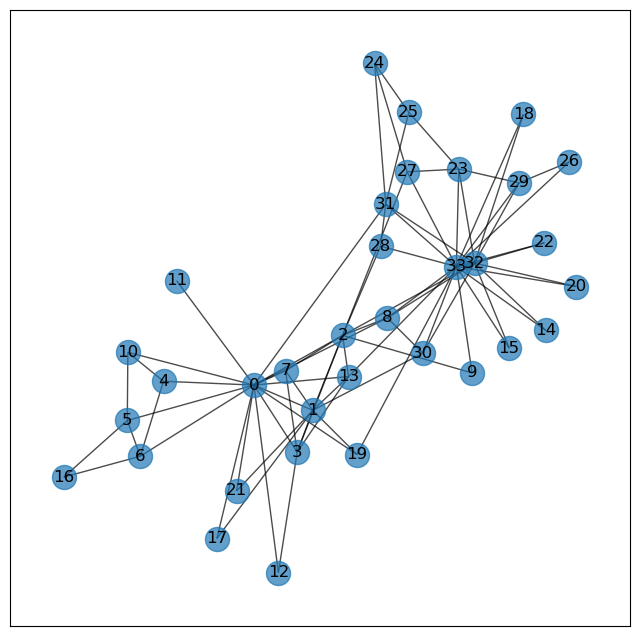

In [356]:
g_karate = nx.karate_club_graph()
draw_spring(g_karate)

In the table below we can see three scores:
1. Degree scores, i.e., the number of neighbors a node has.
2. Degree centrality, not normalized (deg_centrality), i.e., the degree scores presented in proportion to the number of *nodes* in the network. 
3. Normalized degree centrality (deg_c_norm), i.e., the degree scores presented in proportion to the number of *edges* in the network. 

In [357]:
degree_centrality = nx.degree_centrality(g_karate)
resdf_karate = dataframe_from_results(g_karate, degree_centrality,"deg_cent")
resdf_karate['dc_norm'] = score_normalize(degree_centrality)
resdf_karate['degree'] = list(dict(nx.degree(g_karate)).values())
resdf_karate = resdf_karate[['degree', 'deg_cent','dc_norm']]
resdf_karate.sort_values("degree", ascending=False)

,degree,deg_cent,dc_norm
nodes,,,
33,17,0.515,0.109
0,16,0.485,0.103
32,12,0.364,0.077
2,10,0.303,0.064
1,9,0.273,0.058
3,6,0.182,0.038
31,6,0.182,0.038
23,5,0.152,0.032
8,5,0.152,0.032


The hypothesis is that the President and the instructor of the Karate Club would be the nodes with the highest degree or degree centrality scores. From our table these are nodes 33 and 0. This is in fact the case. The instructor is node 33 and the president is node 0. (In Zachary's original paper, the instructor is node 34 and the President node 1, but Python has the convention to start numbering at 0, and so the numbering changes in the ```networkx``` version of this network)

We can conduct a similar exercise for the drone legislation network. Below, we plot the same network as in Chapter 2.

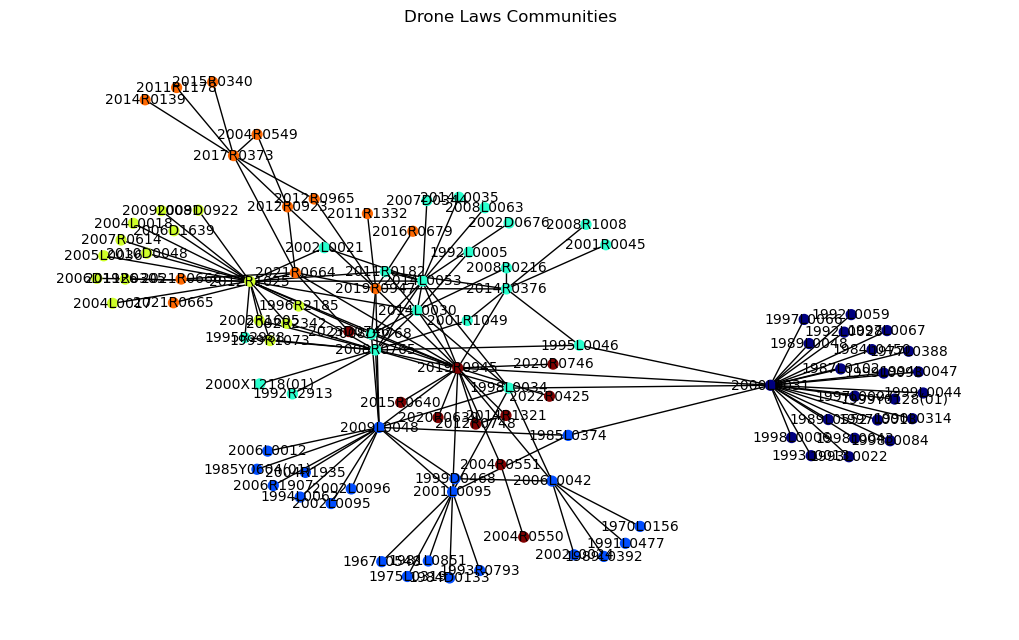

In [358]:
import json
# Load the JSON data
with open("data/drone_laws/g_dronelaws_2.json") as f:
    data = json.load(f)
# Create a directed graph from the data
g_drones = nx.DiGraph()
# Add nodes
for node in data['nodes']:
    g_drones.add_node(node['id'])
# Add edges
for link in data['links']:
    g_drones.add_edge(link['source'], link['target'])
# Convert to undirected graph for community detection
g_drones_undirected = g_drones.to_undirected()
# Detect communities using the greedy modularity method
communities = community.greedy_modularity_communities(g_drones_undirected)
# Create a color map for the communities
color_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i
# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(g_drones_undirected)  # positions for all nodes
# Draw nodes with colors based on their community
node_colors = [color_map[node] for node in g_drones_undirected.nodes()]
nx.draw(g_drones_undirected, pos, with_labels=True, node_color=node_colors, 
        node_size=50, font_size=10, cmap=plt.cm.jet)
# Show the plot
plt.title("Drone Laws Communities")
plt.show()


When we calculate the degree and degree centrality (normalized and non-normalized) scores and rank the scores in descending order, we can observe which laws have how many connections. From the results we can infer that the Directive on electronic commerce (2000L0031) has the most neighbors. An inspection of the network shows why: The Directive on electronic commerce (node located on the right of the plot) is cited by many laws. A deeper investigation into the nodes connected to the Directive would result in the conclusion that many of the nodes citing the electronic commerce Directive has no relationship with drones. 

A similar observation can be made for the second-ranked node on the list, the Regulation on European standardisation (2012R1025). This node can be found on the left of the screen (in light green) and also is citing many laws that are not immediately relevant for drone legislation. The third-ranked node (2019R0945) *is* relevant, but its centrality can be explained by how the network was constructed, as it is one of the two source nodes.

The Degree approach to identify central legislation based on Degree turns out not to be very fruitful, at least not for the drone legislation network.

In [359]:
degree_centrality = nx.degree_centrality(g_drones)
resdf_drones = dataframe_from_results(g_drones, degree_centrality,"deg_cent")
resdf_drones['deg_cent_norm'] = score_normalize(degree_centrality)
resdf_drones['degree'] = list(dict(nx.degree(g_drones)).values())
resdf_drones_deg = resdf_drones[['degree', 'deg_cent','deg_cent_norm']]
resdf_drones_deg.sort_values("degree", ascending=False)

,degree,deg_cent,deg_cent_norm
nodes,,,
2000L0031,25,0.248,0.086
2012R1025,21,0.208,0.072
2019R0945,20,0.198,0.069
2009L0048,15,0.149,0.052
2008R0765,14,0.139,0.048
...,...,...,...
2002L0024,1,0.010,0.003
1967L0548,1,0.010,0.003
2011R0305,1,0.010,0.003


Below, we enter into the nuts and bolts of this metric. We will introduce some simple mathematical notation (which, we will see, involves nothing more complicated than calculating averages) and make the distinction between undirected and directed versions of degree centrality.

#### A) Undirected degree centrality

Undirected degree centrality simply considers the degree score of each nodes, taking into account the number of nodes the network has minus 1. In terms of notation, degree centrality can be represented by the following formula:

$$ \frac{degree(n)}{|N|-1} \mid n \in N $$

In the formula, the large N refers to the set of all the nodes in the network. The small n refers to any particular node, whereas $ degree $ is a function that takes a node n, and returns how many edges that node has. The $ \mid n \in N $ specifies that n is a node belonging to the set of nodes in the network N. 

Remember that the degree score is divided by the total number of nodes in the network to contextualize the score. The subtraction of 1 is done to unbias the calculation by removing the node being considered from the total number of nodes. For all but the smallest networks this operation has very little practical effect, and some practical implementations of the algorithm will not bother to subtract 1.

The vertical bars in $ |N| $ refer to the cardinality of the nodes in the network. In set theory, cardinality is simply the number of items a set has. So the cardinality of the set of colors {blue, green, yellow} is 3. The cardinality of the set of days in the week is 7, etc. Mathematical notation, however, is contextual. The vertical bars around N are sometimes used to mean something else, so one must interpret them in the context of what is being discussed (sometimes, the formula might simply write "N", on the assumption that it is obvious that it refers to the number of nodes in the Network of which "n" is but one).

Since the calculation is very simple, it makes sense to try to apply the formula "by hand". Lets do this for Karate Club  Members 33 and 0, the instructor and the President. First for the instructor:

$$ \frac{degree(KCmember33)}{|N|-1} $$

Filling in the blanks: 

$$ \frac{17}{34-1} = 0.515 $$

Now for the President:

$$ \frac{degree(KCmember0)}{|N|-1} $$

Filling in the blanks: 

$$ \frac{16}{34-1} = 0.485	 $$

You can verify in the table that outsourcing the calculations to a machine yields the same results.

#### B) Directed (in-degree and out-degree) centrality

In directed networks, one can differentiate between in-degree (the number of nodes that have an edge pointing to a given node) and out-degree (the number of nodes that a given node points out to). 

The directed versions of degree centrality are more naturally applied to citation networks where it is crucial to distinguish between nodes receiving a lot of citations ("authorities") and those sending a lot of citations ("hubs"). Because it is originally directed, the drone laws citations network provides a natural example for these algorithms.

In our drone legislation network, we find that the most frequently cited law concerns Directive 2014/53/EU on the making available on the market of radio equipment (2014L0053), followed by Decision No 768/2008/EC on a common framework for the marketing of products (2008D0768), Regulation 2019/947 on the rules and procedures for the operation of unmanned aircraft (2019R0947) and Regulation 765/2008 on the requirements for accreditation and market surveillance relating to the marketing of products (2008R0765).

In [360]:
g_drones_directed = load_graph_from_json("data/drone_laws/g_dronelaws_2.json")
resdf_drones_directed = pd.DataFrame()
resdf_drones_directed.loc[:,"nodes"] = list(g_drones_directed.nodes)
resdf_drones_directed['indegree'] = list(dict(g_drones_directed.in_degree()).values())
indeg_cent = nx.in_degree_centrality(g_drones_directed)
resdf_drones_directed.loc[:, "indeg_cent"] = indeg_cent.values()
indeg_cent_norm = score_normalize(indeg_cent)
resdf_drones_directed['indeg_cent_norm'] = indeg_cent_norm
resdf_drones_directed

/opt/anaconda3/envs/netenv2/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


,nodes,indegree,indeg_cent,indeg_cent_norm
0,2006L0042,0,0.000,0.000
1,2002L0024,1,0.010,0.007
2,2000L0031,0,0.000,0.000
3,1987L0102,1,0.010,0.007
4,2019R0945,2,0.020,0.014
...,...,...,...,...
97,2006L0012,1,0.010,0.007
98,2015R0640,1,0.010,0.007
99,1994L0062,1,0.010,0.007
100,1993L0022,1,0.010,0.007


We can also check this manually. We do this for the three highest scoring nodes with the following in-degree scores:

In [361]:
Node1 = '2014L0053'
Node2 = '2008D0768'
Node3 = '2019R0947'
print("Number of incoming citations for", Node1, ":", [y for x,y in dict(g_drones.in_degree()).items() if x == Node1])
print("Number of incoming citations for", Node2, ":", [y for x,y in dict(g_drones.in_degree()).items() if x == Node2])
print("Number of incoming citations for", Node3, ":", [y for x,y in dict(g_drones.in_degree()).items() if x == Node3])

Number of incoming citations for 2014L0053 : [7]
Number of incoming citations for 2008D0768 : [6]
Number of incoming citations for 2019R0947 : [5]


We can calculate the centrality by dividing the in-degree value for the highest-scoring node by the number of nodes -1

$$ \frac{indegree(2014L0053 )}{|N|-1} $$

or 

$$ \frac{7}{102-1} = 0.069 $$

This is the same result we see above.

Now let us do the same calculation for out-degree. Here, we observe that the highest-scoring laws mostly coincide with ones we identified when we calculated and ranked the judgments based on degree.

In [362]:
resdf_drones_directed['outdegree'] = list(dict(g_drones_directed.out_degree()).values())
outdeg_cent = nx.out_degree_centrality(g_drones_directed)
resdf_drones_directed.loc[:, "outdeg_cent"] = indeg_cent.values()
outdeg_cent_norm = score_normalize(outdeg_cent)
resdf_drones_directed['outdeg_cent_norm'] = outdeg_cent_norm
resdf_drones_directed

,nodes,indegree,indeg_cent,indeg_cent_norm,outdegree,outdeg_cent,outdeg_cent_norm
0,2006L0042,0,0.000,0.000,7,0.000,0.048
1,2002L0024,1,0.010,0.007,0,0.010,0.000
2,2000L0031,0,0.000,0.000,25,0.000,0.172
3,1987L0102,1,0.010,0.007,0,0.010,0.000
4,2019R0945,2,0.020,0.014,18,0.020,0.124
...,...,...,...,...,...,...,...
97,2006L0012,1,0.010,0.007,0,0.010,0.000
98,2015R0640,1,0.010,0.007,0,0.010,0.000
99,1994L0062,1,0.010,0.007,0,0.010,0.000
100,1993L0022,1,0.010,0.007,0,0.010,0.000


Also these results we can replicate:

In [363]:
Node1 = '2000L0031'
Node2 = '2012R1025'
Node3 = '2019R0945'
print("Number of outgoing citations for", Node1, ":", [y for x,y in dict(g_drones.out_degree()).items() if x == Node1])
print("Number of outgoing citations for", Node2, ":", [y for x,y in dict(g_drones.out_degree()).items() if x == Node2])
print("Number of outgoing citations for", Node3, ":", [y for x,y in dict(g_drones.out_degree()).items() if x == Node3])

Number of outgoing citations for 2000L0031 : [25]
Number of outgoing citations for 2012R1025 : [20]
Number of outgoing citations for 2019R0945 : [18]


Now let us divide the out-degree value for the highest-scoring node by the number of nodes -1

$$ \frac{outdegree(2000L0031)}{|N|-1} $$

or 

$$ \frac{25}{102-1} = 0.025 $$

These are the same result we see above.

### 3.2 Closeness Centrality

Degree, in-degree, and out-degree (centrality) consider the direct neighbors of a node, but not the indirect neighbors. For instance, if A is connected to B and B is connected to C, the indirect relationship between A and C - through B - is not taken into consideration in the degree-based measures we have explored. 

Depending on the task at hand, this can be an important oversight. For example if we want to make a model of corporations that are linked through supply chains, we should not be interested only in direct suppliers, but in suppliers that are downstream or upstream from the company under study. Just as in the supply chain example, focusing solely on direct citations might overlook important connections when analyzing a citation network of court decisions. Cases indirectly connected to Case A through the cases it cites (or cases citing it) could also be influential, even if they are not directly cited by Case A. This indirect influence could be crucial in understanding the principle established in Case A. It might, for instance, reveal additional cases that have interpreted or applied the principle in different contexts. 

Closeness centrality is a measure that takes such indirect relationships into consideration. While it is a bit more complicated than degree centrality, it is also relatively easy to understand and calculate. The only difficulty here is is that it relies on shortest path information, and getting the shortest path between two nodes can be a non-trivial problem. From a user perspective this is not a significant issue, as machines will readily provide this info, although finding shortest paths in a very complex networks might become computationally expensive.

Closeness centrality expresses the average closeness between a target node $ u $ and the set of all other nodes it can reach $ V $, when taking the shortest path between the node under examination and the reachable nodes (this shortest path is often called the 'geodesic path'). The greater the average closeness of one node to all other nodes using the shortest paths, the more central the node is. Remember here that closeness is the reciprocal of the distance thus:

$$ closeness = \frac{1}{distance} $$

 The details on this algorithm are provided below.

The importance of closeness centrality becomes most evident when we have nodes that have a "tail" behind them. They have one direct neighbor, but many indirect neighbors standing in line behind them. This is literally what we see when do the analysis for the kite graph, with the tail of the kite being constituted by nodes 7, 8 and 9. Lets first recall the structure of this graph:



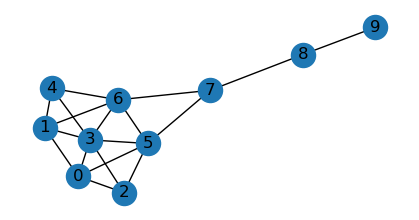

In [364]:
g_kite = nx.krackhardt_kite_graph()

plt.figure(figsize=(4, 2))  
pos = nx.spring_layout(g_kite, seed=10)  # Fixed layout with a seed
nx.draw(g_kite, pos, with_labels=True) 
plt.show()

In terms of degree, node 3 is the clear winner in the first position. Node 7 is far behind on the 8th position.


In [365]:
degree_centrality = nx.degree_centrality(g_kite)
resdf_kite = dataframe_from_results(g_kite, degree_centrality, "deg_cent")
resdf_kite['deg_cent_norm'] = score_normalize(degree_centrality)
resdf_kite.sort_values('deg_cent', ascending=False)

,deg_cent,deg_cent_norm
nodes,,
3,0.667,0.167
5,0.556,0.139
6,0.556,0.139
0,0.444,0.111
1,0.444,0.111
2,0.333,0.083
4,0.333,0.083
7,0.333,0.083
8,0.222,0.056


One might think that node 7 is undervalued. It has only 3 direct neighbors, but it actually has many indirect neighbors, including nodes 8 and 9, that can only be reached by passing through 7. Let us see how 7 fares when using closeness centrality. It turns out that things change quite a bit. Now node 7 moves up from being in the 8th position to being tied for 3rd! 

In [366]:
resdf_kite['closeness'] = nx.closeness_centrality(g_kite).values()
resdf_kite['closec_norm'] = score_normalize(resdf_kite.closeness, from_dictionary=False)
resdf_kite.sort_values('closec_norm', ascending=False)

,deg_cent,deg_cent_norm,closeness,closec_norm
nodes,,,,
5,0.556,0.139,0.643,0.122
6,0.556,0.139,0.643,0.122
3,0.667,0.167,0.600,0.114
7,0.333,0.083,0.600,0.114
0,0.444,0.111,0.529,0.100
1,0.444,0.111,0.529,0.100
2,0.333,0.083,0.500,0.095
4,0.333,0.083,0.500,0.095
8,0.222,0.056,0.429,0.081



In fact other scores also change.  Node 3 is no longer the winner. Under closeness node 3 is penalized for having long paths for nodes 8 and 9. Nodes 5 and 6 obtain better scores. They have less nodes directly linking to them, but they are closer to the other nodes, which is what is relevant for closeness centrality.

One might intuitively say that node 7 is still underperforming in relation of its real importance. If we cut out node 7, the network becomes disconnected. This is not so if you cut any node from 0 to 6. This will come back when we consider betweenness centrality.

So which one is better? Degree centrality or closeness? What is crucial to note for now is how different they are. Domain knowledge is needed to see which one matters most for a given application. Here we can compare the outputs of these two measures directly (blue indicates a higher closeness centrality score than a degree centrality scores, blue the opposite). 


<Axes: xlabel='nodes', ylabel='deg_cent_norm'>

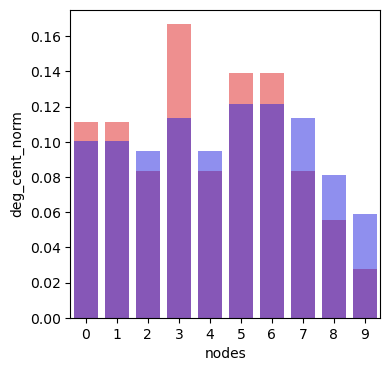

In [367]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
sns.barplot(x = resdf_kite.index, y = resdf_kite.deg_cent_norm, alpha=0.5, ax=ax, color="red")
sns.barplot(x = resdf_kite.index, y= resdf_kite.closec_norm, alpha=0.5, ax=ax, color="blue")

The only real difficulty in closeness centrality is getting the shortest paths. While this is a non-trivial and computationally expensive task, from the user persepctive, a machine can calculate shortest paths for us. Let us use a machine to try to unpack the algorithm. Here we get the number of steps from node 8 to every other node.

In [368]:
nx.single_source_shortest_path_length(g_kite, source = 8)

{8: 0, 7: 1, 9: 1, 5: 2, 6: 2, 0: 3, 2: 3, 3: 3, 1: 3, 4: 3}

Or if you just want to see the itinerary, and not the number of steps:

In [369]:
nx.shortest_path(g_kite, source = 8, target= 6 )

[8, 7, 6]

We can perform a similar operation for our drone legislation network we used previously. We first visuallly compare normalized degree centrality with normalized closeness centrality. We observe quite some differences in rankings between the two measures:

<Axes: xlabel='deg_cent_norm', ylabel='Count'>

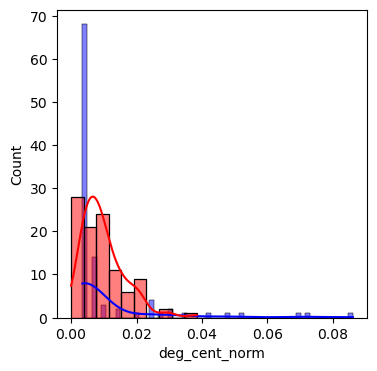

In [370]:
resdf_drones['closeness'] = nx.closeness_centrality(g_drones).values()
resdf_drones['closec_norm'] = score_normalize(resdf_drones.closeness, from_dictionary=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
sns.histplot(resdf_drones.deg_cent_norm, ax=ax, color="blue", alpha=0.5, kde=True)
sns.histplot(resdf_drones.closec_norm, ax=ax, color="red", alpha=0.5, kde=True)

Compared to the ranking based on degree, we now encounter more aviation-specific laws in the top-5 of laws with the highest closeness centrality. For instance, Regulation 965/2012 on the technical requirements and administrative procedures related to air operations and Regulation 1332/2011 on common airspace usage requirements and operating procedures for airborne collision avoidance appear in the top-5, along with Regulation 2019/947 on the rules and procedures for the operation of unmanned aircraft. This ranking seems to have yielded more directly relevant laws to drones.

In [371]:
resdf_drones.sort_values("deg_cent_norm", ascending=False)
resdf_drones['closeness'] = nx.closeness_centrality(g_drones).values()
resdf_drones['closec_norm'] = score_normalize(resdf_drones.closeness, from_dictionary=False)
resdf_drones_deg_cent = resdf_drones[['deg_cent_norm', 'closec_norm']]
resdf_drones_deg_cent.sort_values('closec_norm', ascending=False)

,deg_cent_norm,closec_norm
nodes,,
2008D0768,0.021,0.038
2019R0947,0.031,0.030
2014L0053,0.041,0.029
2012R0965,0.007,0.022
2011R1332,0.003,0.021
...,...,...
1997L0007,0.003,0.004
1989L0392,0.003,0.004
2021R0665,0.003,0.000


Also for the drone legislation network, we can select a node and find the shortest paths to all other connected (directly or indirectly) nodes in the network.

In [372]:
nx.single_source_shortest_path_length(g_drones, source = '2019R0945')

{'2019R0945': 0,
 '2012R1025': 1,
 '2012R0748': 1,
 '2008R0765': 1,
 '2004R0551': 1,
 '2021R0664': 1,
 '2014L0030': 1,
 '2001L0095': 1,
 '2014L0053': 1,
 '2020R0746': 1,
 '2019R0947': 1,
 '2009L0048': 1,
 '2022R0425': 1,
 '2020R0639': 1,
 '2014R1321': 1,
 '2023D0746': 1,
 '2008D0768': 1,
 '2015R0640': 1,
 '2014R0376': 1,
 '1996R2185': 2,
 '2011R0182': 2,
 '2002L0021': 2,
 '2002R2342': 2,
 '2006D1639': 2,
 '1995R2988': 2,
 '2009L0081': 2,
 '2004L0017': 2,
 '2011R0305': 2,
 '2005L0036': 2,
 '2009D0922': 2,
 '2006D1926': 2,
 '2002R1605': 2,
 '1999R1073': 2,
 '2007R0614': 2,
 '2010D0048': 2,
 '2004L0018': 2,
 '2001R1049': 2,
 '1992R2913': 2,
 '1995L0046': 2,
 '2000X1218(01)': 2,
 '2004R0550': 2,
 '2017R0373': 2,
 '2021R0666': 2,
 '2012R0923': 2,
 '1992L0005': 2,
 '2008R0216': 2,
 '1984D0133': 2,
 '1993R0793': 2,
 '1967L0548': 2,
 '1981L0851': 2,
 '1975L0319': 2,
 '1999D0468': 2,
 '1985L0374': 2,
 '2002D0676': 2,
 '2008L0063': 2,
 '2014L0035': 2,
 '2007D0344': 2,
 '2011R1332': 2,
 '2016R067

And we can show which laws we encounter when we take the shortest path from a start and end point (source and target node) that we select.

In [373]:
nx.shortest_path(g_drones, source = '2019R0945', target= '2021R0666')

['2019R0945', '2021R0664', '2021R0666']

If you have the itinerary, you can use ```len``` to get the number of steps. Because the itinerary counts the origin node, you should subtract 1 from the result.

Now having the shortest path score, let's move to calculate closeness centrality. The formula here is:

$$ \frac{|V|-1}{\sum_{V_1}^{V_n}spath(v,u)} $$

Even more than with degree centrality, this formula can appear intimidating at first glance, but it is in fact rather straightforward.

In this formula, the number of nodes $ v $ that can reach a certain specific node $ u $ minus 1 is expressed by $ |V|-1 $. This top part of the formula is nothing that we have not encountered before.

The bottom part of the formula represents the sum of the shortest path lengths between each of those nodes $ v $ and $ u $. Here the notation can be a bit tricky so it is worth explaining it step by step.

By $spath(v,u)$ we understand a function that gives us the shortest path between a target node $u$ and every node $v$ that can reach $ u $. In this context, it is customary to denote sets with capital letters, and elements of that set with the same letter uncapitalized, so $v$ represents every node in $V$.

The $\Sigma$ represents a sum in the so-called Sigma notation. The $ \Sigma $ means 'sum', the subscript denotes the element where the sum begins, and the superscript the element where it ends. So in order to express a sum through the sequence a, b, c and d, we can just write: $ \sum_{a}^{d} $ 

So in our case, the $\sum_{V_1}^{V_n}spath(v,u)$ represents the sum of all those shortest paths for every node $v$, starting from the first element of the set V, node $v_1$, to the last element of the set V referred to as $v_n$.
. 


#### A) Closeness with weights

We previously explained that edges can have weights and that networks can be fully connected. A network of document similarity scores will typically have both of these features: similarity scores provide the weight, and every document is compared to every other document, resulting in a fully connected network. 

What would be the expected result of running the closeness centrality algorithm on this network without specifying any weight information? The result would be that all nodes are equally, and maximally, close to each other, all getting a closeness centrality score of 1. We can see this in the example below:

/opt/anaconda3/envs/netenv2/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


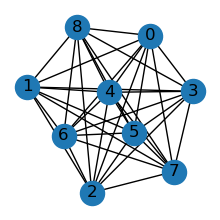

In [374]:
g_docs = load_graph_from_json("data/g_docs.json")
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(g_docs, seed=10) # Fixed layout with a seed
nx.draw_spring(g_docs, with_labels=True) 
plt.show()

In [375]:
closeness_centrality = nx.closeness_centrality(g_docs)
resdf_docs = dataframe_from_results(g_docs, closeness_centrality, "closec")
resdf_docs

,closec
nodes,
0,1.000
1,1.000
2,1.000
3,1.000
4,1.000
5,1.000
6,1.000
7,1.000
8,1.000


To avoid this uninformative result, it is possible to adjust the closeness to consider the weights, with the weights indicating document similarity (the higher the weight, the more similar the document).

Adding weight information does not require us to change the formula in any substantial way. The only thing that changes is that the function returning the shortest path now considers not only discrete steps, but weighted steps, which we may signal by adding the $ w $ subscript to the formula: 

$$ \frac{|V|-1}{\sum_{V_1}^{V_n}spath_w(v,u)} $$

Weighted shortest paths were discussed in Chapter 2, section E.

Redeploying our measure, now with weights, provides more informative results that we can see below:



In [376]:
closeness_centrality_weighted = nx.closeness_centrality(g_docs, distance='weight')
resdf_docs['closec_w'] = closeness_centrality_weighted
resdf_docs.sort_values("closec_w", ascending=False)

,closec,closec_w
nodes,,
8,1.000,2.799
1,1.000,2.724
2,1.000,2.702
7,1.000,2.566
3,1.000,2.515
0,1.000,2.503
5,1.000,1.978
6,1.000,1.866
4,1.000,1.233


It is good to know that closeness centrality takes into consideration how well-connected a node is (the numerator of the formula increases when more nodes can reach the node of interest). Consider the following example, where nodes D and E have a single very short path between them. This path is very short, but it is penalized by the very small numerator, as D and E can only be reached by one other node.

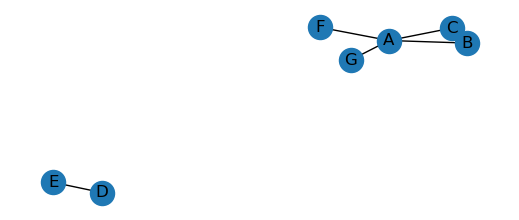

In [377]:
g_disconnected = nx.Graph()
g_disconnected.add_nodes_from(['A','B','C','D','E','F','G'])
g_disconnected.add_edges_from([('A','B'),('B','C'), ('C','A'), ('A','F'),('A','G'),('D','E')])
plt.figure(figsize=(5, 2))
nx.draw_spring(g_disconnected, with_labels=True) 
plt.show()

In [378]:
closeness_centrality = nx.closeness_centrality(g_disconnected, distance='weight')
resdf_disconnected = dataframe_from_results(g_disconnected, closeness_centrality, "closec_w")
resdf_disconnected.sort_values("closec_w", ascending=False)

,closec_w
nodes,
A,0.667
B,0.444
C,0.444
F,0.381
G,0.381
D,0.167
E,0.167


## 3.3 Eigenvector Centrality

Another approach to determine the centrality of a node is to consider how likely it is to reach that node if one would randomly 'walk' through the network. If a node would be reached more frequently than other nodes, this could signal that the node is more central and consequently more relevant. 

Eigenvector centrality can be understood on the basis of this 'random walker' idea. It simulates a random walker moving from node to node, each time with equal probability of going to the adjacent node. The idea is that if the walk goes on for very long, the probability of seeing the walker at a particular node will stabilize, giving you the Eigenvector Centrality value. 


Recall that degree centrality favors the number of direct neighbors one has, closeness centrality takes into account indirect networks, including thus nodes that are in a "tail" formation behind a node. 

Eigenvector centrality takes into consideration the probabilities that one may move from one appear in one node, and this is a function of how well connected that node is, and also of how well connected the nodes around it are. By virtue of this, one added value of eigenvector centrality is that it takes into consideration the relative importance of nodes. In other words: A node gets a high eigenvector centrality score if it is linked to other nodes which also have a high eigenvector centrality score. Intuitively, consider that "famous" may be defined (at least partly) in terms of having many friends who are also "famous". 

Let us go back to the kite and remember that:
* Degree centrality prefers node 3, and puts node 7 far on the back.
* Closeness prefer both 5 and 6, and puts node 7 in 4th place
Here we will see that Eigenvector centrality also prefers node 3, and also puts node 7 far on the back. Note why this might be so. Node 3 not only has high degree, but it is also close to nodes 5, 6, 0 and 1, which also have high degree. By contrast node 7 is "friends" with 5 and 6, but also with the unpopular 8, so it cannot rank as high.

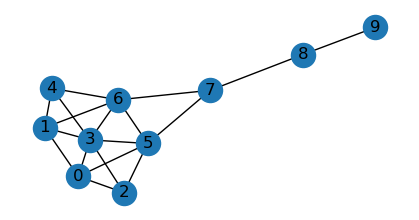

In [379]:
plt.figure(figsize=(4, 2))  
pos = nx.spring_layout(g_kite, seed=10)  # Fixed layout with a seed
nx.draw(g_kite, pos, with_labels=True) 
plt.show()

We can see the scores here. 

In [380]:
eigenvector_centrality_kite = list(nx.eigenvector_centrality(g_kite).values())
resdf_kite['eigc'] = eigenvector_centrality_kite
resdf_kite['eigc_norm'] = score_normalize(resdf_kite.eigc, from_dictionary=False)
resdf_kite_eigc = resdf_kite[['eigc', 'eigc_norm']]
resdf_kite_eigc.sort_values("eigc", ascending=False)

,eigc,eigc_norm
nodes,,
3,0.481,0.171
5,0.398,0.142
6,0.398,0.142
0,0.352,0.125
1,0.352,0.125
2,0.286,0.102
4,0.286,0.102
7,0.196,0.070
8,0.048,0.017


Notice how the unnormalized scores are not really comparable but the normalized scores are. Node 3 in the kite is pretty much always central, so the scores should be roughly the same. But because unnormalized scores do not have a common metric, they reflect some misleading variation and have a meaningless metric on the y axis (which has therefore been removed in the plot below). Using only the normalized scores provides a clearer picture.

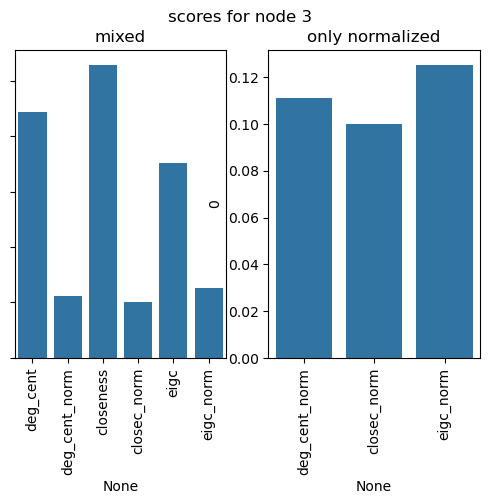

In [381]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))
plt.suptitle("scores for node 3")
sns.barplot(x = resdf_kite.columns, y= resdf_kite.loc[0,:], ax = ax[0]).set(yticklabels=[], ylabel=None)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("mixed")

sns.barplot(x = resdf_kite.drop(["deg_cent", "closeness", "eigc"], axis=1).columns, 
            y= resdf_kite.drop(["deg_cent", "closeness", "eigc"], axis=1).loc[0,:], ax = ax[1])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("only normalized");

An advantage of eigenvector centrality (and measures similar to it computationally like Pagerank or HITS) is that it relies on matrix multiplications instead of shortest path calculations. Because modern computers are highly optimized to perform matrix multiplications, eigenvector centrality (and similar measures) may perform better in large networks than simpler measures like closeness or betweenness.

The mathematics of Eigenvector Centrality are somewhat omplicated, in particular for non-technical persons. We are not going to present it in full, but we will, in the next example, sketch an idea of how Eigenvector Centrality works and some ways of arriving at it. 

In its simplest form, Eigenvector Centrality is what you get by repeatedly multiplying: 

* an **adjacency matrix** by 
* a **vector of probabilities** associated with each node.

Let us use a small network to illustrate. Imagine we have four nodes "a", "b", "c" and "d", and we are making a network of their linkages. We begin representing this network as a $ 4 \times 4 $ adjacency matrix $A$ (it is customary to represent matrices with capital letters). In this matrix a 1 indicates there is a connection between a node in the rows and another in the columns, and a 0 means that there is no connection. If one picks node "a" in the rows, we see that it connects to "b" and "c" in the columns. If we read the row of node "b", we see that it connects with "a" and "d" in the columns. And so on. 

$$ A = \begin{pmatrix}
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
\end{pmatrix} $$

For the vector of probabilities "v", we can just assume that one is equally likely to be in each of the four nodes of the matrix (as we repeatedly multiply $A$ and $v$ the values of $v$ will change).

$$ v = \begin{pmatrix}{0.25,0.25,0.25,0.25}\end{pmatrix} $$

The basic idea is that if one multiplies $ A $ and $ v $ one will "apply" the structure of the adjacency matrix to the vector, or "scale" the vector by the matrix. In every such multiplication, we will have a transition or "walk" from the equal probability starting point $ v = \begin{pmatrix}{0.25,0.25,0.25,0.25}\end{pmatrix} $ to some other state. If one does this multiple times, updating the value of "v" in every iteration, it is possible that the values will "converge" or stabilize, which means they will not change much from multiplication to multiplication. The now stable values of $ v $ represent the probability that the random walker will be in a particular row of the matrix (or node of the network) after an indeterminate number of walks. 

In mathematical notation this repeated updating by matrix - vector multiplication may be expressed in this manner (note that $ := $ here emphasizes that we are assigning a value, and not asserting an equality).

$$ v_{i+1}:= Av_{i} $$

This is done for values of $ i = {1, 2, 3, 4, ...} $ until it is the case that the values of $ v $ do not change from multiplication to multiplication. We may express this as an approximate equality because one may be satisfied with very small variations in the score of v, instead of requiring it to be be exactly the same.

$$ v_{i+1} \approx v_{i} $$

Once we are satisfied with the result the vector should be "normalized" by dividing it by its norm. This is done because what interests us is the relative magnitude associated with each node, and not absolute values, which can be very large due to the repeated multiplication (There may be technical reasons to normalize after each iteration of the multiplication, instead of just at the end, this may avoid numbers becoming too large and difficult to calculate).

$$ \frac{v}{||v||} $$

Why is this called Eigenvector Centrality? Because a property of the adjacency matrix, namely, the Eigenvector associated with its highest Eigenvalue, will give the same results as the method presented above. But before showing this, let us put procedure in practice. We first create the adjacency matrix of the kite graph.

In [382]:
A = nx.adjacency_matrix(g_kite)
A.todense()

array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

The next step is to have an initial vector of probabilities. Each element of this vector should be 1/10 or 0.1. Remember that probabilities have to sum to 1, and if it is equally probable that one may be in each of the 10 nodes of the kite graph, then we have a 0.1 probability for each.

In [383]:
v = (np.ones(10)/10)
v

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Finally we repeatedly multiply the adjacency matrix by the vector of probabilities and normalize the results. We will just do it 100 times. In more complicated scenarios, more repetitions might be required to do the trick. Note that in ```numpy``` the operator ```@``` is used to express matrix multiplication.

After the multiplications are done, we normalize the results by dividing the results vector by its norm.

Here we can see how this 'by-hand' approach matches with the ```networkx``` built-in function

In [384]:
A = nx.adjacency_matrix(g_kite)
v = (np.ones(10)/10)

for i in range(0,100):
    v = A@v
vnorm = np.linalg.norm(v)
vresult = v / vnorm

resdf_kite['vresult'] = vresult
resdf_kite

,deg_cent,deg_cent_norm,closeness,closec_norm,eigc,eigc_norm,vresult
nodes,,,,,,,
0,0.444,0.111,0.529,0.100,0.352,0.125,0.352
1,0.444,0.111,0.529,0.100,0.352,0.125,0.352
2,0.333,0.083,0.500,0.095,0.286,0.102,0.286
3,0.667,0.167,0.600,0.114,0.481,0.171,0.481
4,0.333,0.083,0.500,0.095,0.286,0.102,0.286
5,0.556,0.139,0.643,0.122,0.398,0.142,0.398
6,0.556,0.139,0.643,0.122,0.398,0.142,0.398
7,0.333,0.083,0.600,0.114,0.196,0.070,0.196
8,0.222,0.056,0.429,0.081,0.048,0.017,0.048


Finally, let us approach it from the perspective of eigenvalues and eigenvectors. 

Eigenvalues and eigenvectors are a property of certain matrices, which often very difficult to get by hand, but which ```numpy``` can provide on command.

Eigenvectors are just vectors, that when multiplied by the matrix ($ matrix \times vector $), scale, but do not change direction. 

Every eigenvector will have an eigenvalue -a value, that is, just a number- associated with it, which records how much the vector is scaled. Here we are interested in the eigenvector that is associated with the largest eigenvalue.

The largest eigenvalue here is 4.3. This is in index position 0 of the numpy array (arrays like a python list, start from zero). 

In [385]:
A = nx.adjacency_matrix(g_kite)
vals, vecs = np.linalg.eig(A.todense())
vals

array([ 4.30640379,  1.60639741,  1.41421356,  0.64036468, -0.40434195,
       -0.816375  , -1.41421356, -1.46406328, -2.        , -1.86838565])

For all but the smallest networks it can be difficult to visually inspect which value is the largest, here we can use ```numpy.argmax``` to return the position of this value.

In [386]:
np.argmax(vals)

np.int64(0)

So if we want the eigenvector associated with the largest eigenvalue, what we are looking for is the vector at position 0.


In [387]:
vecs[:,0]

array([0.3522094 , 0.3522094 , 0.28583499, 0.48102086, 0.28583499,
       0.39769064, 0.39769064, 0.19586058, 0.04807349, 0.01116326])

Note what is going on here code wise. ```vecs``` gives us all the eigenvectors. 
Each of the eigenvectors (associated with every eigenvalue) is in a column. Using ```vecs[:,0]``` tell us "give me all the rows, under column zero. And that is exactly the same as the repeat multiplication method or the built in ```nx.eigenvector_centrality``` function.

In [388]:
resdf_kite['eigen'] = vecs[:,0]
resdf_kite

,deg_cent,deg_cent_norm,closeness,closec_norm,eigc,eigc_norm,vresult,eigen
nodes,,,,,,,,
0,0.444,0.111,0.529,0.100,0.352,0.125,0.352,0.352
1,0.444,0.111,0.529,0.100,0.352,0.125,0.352,0.352
2,0.333,0.083,0.500,0.095,0.286,0.102,0.286,0.286
3,0.667,0.167,0.600,0.114,0.481,0.171,0.481,0.481
4,0.333,0.083,0.500,0.095,0.286,0.102,0.286,0.286
5,0.556,0.139,0.643,0.122,0.398,0.142,0.398,0.398
6,0.556,0.139,0.643,0.122,0.398,0.142,0.398,0.398
7,0.333,0.083,0.600,0.114,0.196,0.070,0.196,0.196
8,0.222,0.056,0.429,0.081,0.048,0.017,0.048,0.048


It is generally not recommended to use eigenvector centrality on directed networks. This is the case for our drone law legislation, where edges represent a link between one law and another. What happens it that the aforementioned random walker is bound to get stuck in a "sink" node from which no escape is possible -- since the network is directed, if a node has incoming edges and no outgoing edges, it can be entered, but not exited. The result is that such "sink" edges capture the bulk of the random walkers, leading us to an uninformative result we see below:

([], [])

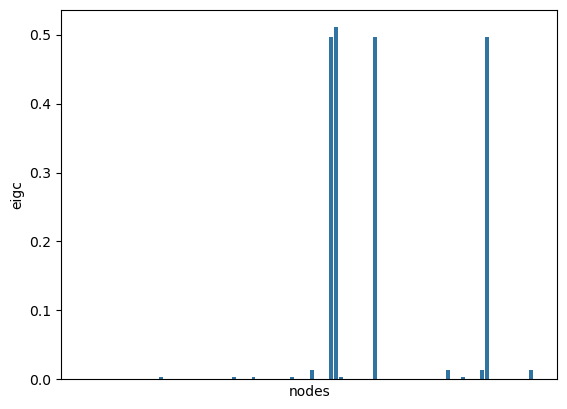

In [389]:
eigenvector_centrality_drones = list(nx.eigenvector_centrality(g_drones, max_iter=1000).values())
resdf_drones['eigc'] = eigenvector_centrality_drones
resdf_drones['eigc_norm'] = score_normalize(resdf_drones.eigc, from_dictionary=False)
resdf_drones.sort_values("eigc", ascending=False)
sns.barplot(resdf_drones["eigc"])
plt.xticks([])


We get more informative results when we pass an undirected network, as is the case of the extraterritorial cases network, which we can see below:

In [390]:
g_extraterritorial = load_graph_from_json("data/extraterritorial_cases_3.json")
resdf_extraterritorial = dataframe_from_results(g_extraterritorial, nx.eigenvector_centrality(g_extraterritorial, weight="weight"), "eigc")
resdf_extraterritorial.sort_values("eigc", ascending=False)

/opt/anaconda3/envs/netenv2/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


,eigc
nodes,
13216/05,0.629
48787/99,0.511
43370/04,0.450
47708/08,0.198
40167/06,0.185
39630/09,0.130
35763/97,0.121
36925/07,0.112
51357/07,0.097


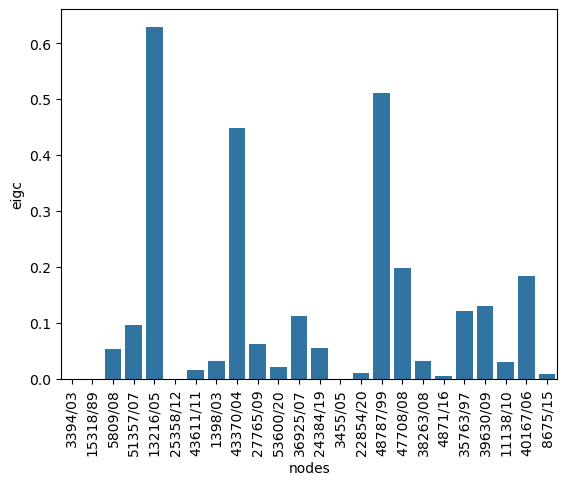

In [391]:
plt.tight_layout
sns.barplot(resdf_extraterritorial["eigc"])
plt.xticks(rotation=90);



## 3.4 PageRank

PageRank is a variant of the Eigenvector centrality which is applicable to directed networks. Like Eigenvector Centrality it considers not only the number of links one receives, but also the popularity of those linking to us. It is also based on the "random walk idea": the Pagerank score corresponds to the likelihood of a user ending up on that page by randomly clicking from link to link. PageRank used to form the basis for the Google search engine algorithm. 

Below, we can see how it might work in a simplified citation network of the American case Obergefell v. Hodges. We will delve into the mathematical explanations behind it a bit. Do not worry if the math is too complicated. For the application of network analysis in the legal domain it can be sufficient to realize that PageRank drops a random walker in the network, lets it traverse many times, teleports the walker when it gets stuck, and counts the number of times the walker passes each node.

<img src="images/ch3/obergefell.png" width="1000" height="750"/>

>Note that here we are using an image instead of the code used to generate it. Currently the package used to generate this image is not being maintained.

In [392]:
g_ob = load_graph_from_json("data/obergefell.json")
resdf_ob = dataframe_from_results(g_ob, nx.pagerank(g_ob), "pagerank")
resdf_ob

/opt/anaconda3/envs/netenv2/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


,pagerank
nodes,
Obergefell_v_Hodges,0.040
Lawrence_v_Texas,0.045
Bowers_v_Hardwick,0.045
Zablocki_v_Redhail,0.045
Turner_v_Safley,0.045
Windsor_v_United_States,0.045
PPvCasey,0.053
Roe_v_Wade,0.063
Griswold_v_Connecticut,0.085


One key difference with Eigenvector Centrality is that PageRank incorporates a "teleportation" factor that is controlled with the ```alpha``` parameter seen above: As a random walker moves through the network, it may get stuck on a node or nodes that has only incoming links to it, and no outgoing links. For example, Loving v. Virginia or Lochner v. New York. The teleportation factors implies a random chance of teleporting anywhere else in the network and thus avoids the random walk getting stuck in such dead ends. Absent the teleportation factor, end nodes (nodes with only incoming links) will tend to absorb all the network flow and give us an uninformative result.

Above we have defined ```alpha``` to equal 75, but the usual value is 85. This implies a $1-alpha$ chance of teleportation, so in this case, a 0.25 chance of teleportation...


Now let us enter into the technical details: 

The first thing PageRank needs, is to transform the adjacency matrix into a transition matrix. While an adjacency matrix will record a 1 if there is a connection between a node in the rows and a node in the column, the transition matrix will record the probability of jumping from a node in the rows to another one in the columns in such a way that the probabilities all sum to 1. 

Imagine once more we have four nodes A, B, C, D, that are connected as follows:

$$ A = \begin{pmatrix}
0 & 1 & 0 & 1 \\ 
1 & 0 & 0 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
\end{pmatrix} $$

If we are in node A (first row), we can jump to node B or D. If we are in node B (second row) we can jump to node A and D. Granting equal probability of making that jump, we now weigh the connection in terms of probabilities as in this manner:

$$ T = \begin{pmatrix}
0 & 0.5 & 0 & 0.5 \\ 
0.5 & 0 & 0 & 0.5 \\ 
\frac{1}{3} & \frac{1}{3} & 0 & \frac{1}{3} \\ 
0 & 0.5 & 0.5 & 0 \\ 
\end{pmatrix} $$

Note that each row will sum to 1 as per the rules of probability.

Just like with Eigenvector centrality, the next thing needed is a vector that reflects the probability of being in each of the nodes of the network. There are four nodes, so a vector with equal probability will be a vector of 0.25s.

$$ v = \begin{pmatrix}
0.25 & 0.25 & 0.25 & 0.25 \\ 
\end{pmatrix}$$

In principle what needs to be done next is to multiply the vector of probabilities by the transpose of the transition matrix many times. 

$$ v_{i+1}:= T^Tv_{i} $$

However, if this algorithm is used, nodes that are sinks (have no outgoing links) or which form a closed circuit can trap all the pagerank scores. So something needs to be changed. What happens is that the transition matrix G is modified by adding a teleportation factor alpha to it, so that for every node there is a 1-alpha chance of getting out.

In NetworkX the transition matrix is called the google matrix. It is for this reason that we have chosen to denote this with the letter G.

$$ G = T * alpha + [(1-alpha)/n]_{nxn} $$

Now we can go ahead and repeatedly multiply G and the vector of probabilities many times to get the results we need.

$$ v_{i+1}:= G^Tv_{i} $$

Just like with Eigenvector Centrality, eventually the values of $v$ will not change much from multiplication to multiplication, leading us to our score.

Pagerank is presented as a percentage, so then we normalize this value by dividing it for its sum:

$$ pagerank = \frac{v}{\sum v} $$


This is how we can get the scores using a for loop.

In [393]:
G = nx.google_matrix(g_ob, alpha=0.75).T
v = np.ones(16)/16

for i in range(0, 1000):
    v = G @ v.reshape(16,-1)
    vnorm = np.linalg.norm(v)
    v = v/vnorm

vresult = np.ravel(v/sum(v))
vresult    

resdf_ob['unofficial'] = vresult
resdf_ob.sort_values("unofficial")

,pagerank,unofficial
nodes,,
Obergefell_v_Hodges,0.040,0.042
Lawrence_v_Texas,0.045,0.046
Bowers_v_Hardwick,0.045,0.046
Zablocki_v_Redhail,0.045,0.046
Turner_v_Safley,0.045,0.046
Windsor_v_United_States,0.045,0.046
Baker_v_Nelson,0.045,0.046
PPvCasey,0.053,0.054
County_of_Sacramento_vs._Lewis,0.053,0.054


And as expected, the eigenvalues associated with the largest eigenvector give us the same result.

In [394]:
A = nx.google_matrix(g_ob, alpha=0.75).T
vals, vecs = np.linalg.eig(A)
argmax = np.argmax(vals)
eigresult = np.ravel(vecs[:,argmax])
eigresult = eigresult/np.sum(eigresult)
resdf_ob['eigen_result'] = np.around(eigresult,3)
resdf_ob

,pagerank,unofficial,eigen_result
nodes,,,
Obergefell_v_Hodges,0.040,0.042,0.042+0.000j
Lawrence_v_Texas,0.045,0.046,0.046+0.000j
Bowers_v_Hardwick,0.045,0.046,0.046+0.000j
Zablocki_v_Redhail,0.045,0.046,0.046+0.000j
Turner_v_Safley,0.045,0.046,0.046+0.000j
Windsor_v_United_States,0.045,0.046,0.046+0.000j
PPvCasey,0.053,0.054,0.054+0.000j
Roe_v_Wade,0.063,0.063,0.063+0.000j
Griswold_v_Connecticut,0.085,0.082,0.082+0.000j


While eigenvector centrality is suited for undirected networks, pagerank is suited for directed networks. This we have ready at hand with the drone legislation citation network. The results can be seen in the dataframe below:

In [395]:
resdf_drones['pagerank'] = nx.pagerank(g_drones)
resdf_drones.sort_values("pagerank", ascending=False)


,deg_cent,deg_cent_norm,degree,closeness,closec_norm,eigc,eigc_norm,pagerank
nodes,,,,,,,,
2014L0053,0.119,0.041,12,0.075,0.029,0.000,0.000,0.024
2008D0768,0.059,0.021,6,0.100,0.038,0.510,0.246,0.019
2019R0947,0.089,0.031,9,0.078,0.030,0.004,0.002,0.019
2014R1321,0.020,0.007,2,0.026,0.010,0.000,0.000,0.016
2021R0664,0.069,0.024,7,0.026,0.010,0.000,0.000,0.015
...,...,...,...,...,...,...,...,...
1994L0047,0.010,0.003,1,0.010,0.004,0.000,0.000,0.008
1977L0388,0.010,0.003,1,0.010,0.004,0.000,0.000,0.008
2021R0665,0.010,0.003,1,0.000,0.000,0.000,0.000,0.008


Do not worry if the math was too complicated. For the application of network analysis in the legal domain it can be sufficient to realize that PageRank drops a random walker in the network, lets it traverse many times, teleports the walker when it gets stuck, and counts the number of times the walker passes each node.

## 3.5 Betweenness Centrality

So far we have been discussing centrality in relation to the number of neighbors a node has. 

1. Degree centrality simply focuses on the number of direct neighbors a node has.
2. Closeness centrality takes into account not just direct neighbors, but also indirectly linked nodes.
3. Eigenvector centrality and Pagerank consider the connectedness or "fame" of the neighbors.

Now we will introduce a different focus. We will consider as most central not just nodes that have a lot of neighbors, but nodes that are "mediators" (or "brokers") in the network. These nodes are the glue that holds the network together. If they are removed, this can cause severe disruption in the network, possibly disconnecting parts of the network. Removing nodes with a high betweenness centrality can be like cutting away the root of a broccoli, causing the broccoli to fall apart in various disconnected pieces. Betweenness centrality considers this broker status. 
To illustrate how betweenness centrality can be determined, we start with the example of actual political brokerage. The "Florentine Families" graph is a study of marriage alliances between families in Renaissance Florence by Breiger and Pattison (1986). The graph of such network of marriage alliances can be seen below:

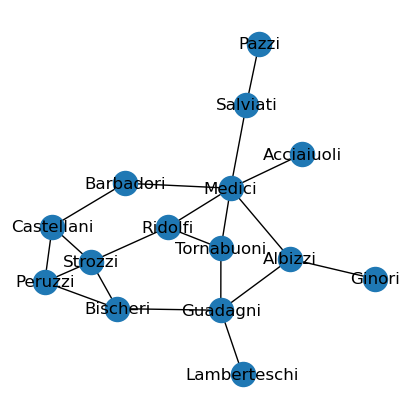

In [396]:
g_florentine = nx.florentine_families_graph()
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(g_florentine, seed=10) # Fixed layout with a seed
nx.draw_spring(g_florentine, with_labels=True)
plt.show()

The Medici were the dominant family of this time period. However, although conventional centrality measures will show that the Medici have a strong political situation, they do not really signal dominance. The closeness score for Medici is 0.09, but Strozzi, Barbadori, Ridolfi, Tornabuouni, Albizzi and Guadagni are not far behind. 

Once we factor in betweenness, the scores for the aforementioned families drop significantly and we get far better impression of the dominance of the Medici.

In [397]:
closeness = nx.closeness_centrality(g_florentine)
betweenness = list(nx.betweenness_centrality(g_florentine).values())

resdf_florentine = dataframe_from_results(g_florentine, closeness, "closec")
resdf_florentine['closec_norm'] = score_normalize(resdf_florentine.closec, from_dictionary=False)
resdf_florentine['betweenness'] = betweenness
resdf_florentine['betweenness_norm'] = score_normalize(resdf_florentine.betweenness, from_dictionary=False)

resdf_florentine

,closec,closec_norm,betweenness,betweenness_norm
nodes,,,,
Acciaiuoli,0.368,0.059,0.000,0.000
Medici,0.560,0.090,0.522,0.304
Castellani,0.389,0.062,0.055,0.032
Peruzzi,0.368,0.059,0.022,0.013
Strozzi,0.438,0.070,0.103,0.060
Barbadori,0.438,0.070,0.093,0.054
Ridolfi,0.500,0.080,0.114,0.066
Tornabuoni,0.483,0.078,0.092,0.053
Albizzi,0.483,0.078,0.212,0.124


Here we can see the massive contrast. The blue bars highlight the closeness centrality, and the red bars betweenness centrality. (If a red bar exceeds a blue bar, this indicates the extent to which the closeness centrality score is higher than the betweenness centrality score.)

<Axes: xlabel='closec_norm', ylabel='nodes'>

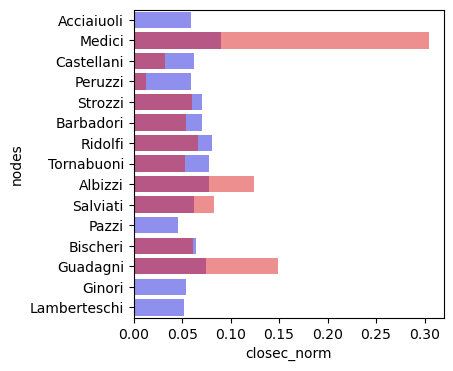

In [398]:
plt.figure(figsize=(4,4))
sns.barplot(y = resdf_florentine.index, x = resdf_florentine.closec_norm, color='blue', alpha =0.5)
sns.barplot(y = resdf_florentine.index, x = resdf_florentine.betweenness_norm, color='red', alpha = 0.5)

Finally, let us see what happens when we remove the Medici family from the graph. As we can see, the graph suddenly becomes disconnected.

In [399]:
g_florentine.nodes

NodeView(('Acciaiuoli', 'Medici', 'Castellani', 'Peruzzi', 'Strozzi', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi'))

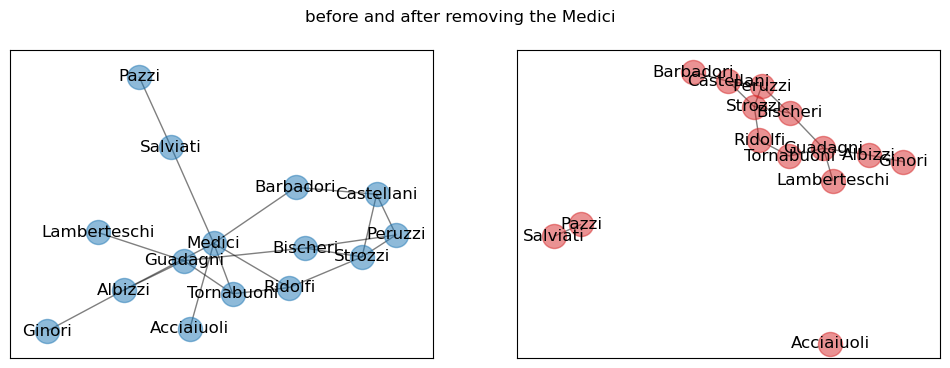

In [400]:
g_subflorentine = g_florentine.subgraph([x for x in g_florentine.nodes if not x=="Medici"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

plt.suptitle("before and after removing the Medici")

pos = nx.spring_layout(g_florentine, seed =123)
nx.draw_networkx_nodes(g_florentine, pos=pos, node_color="tab:blue", node_size=300, alpha=0.5, ax=ax[0])
nx.draw_networkx_edges(g_florentine, pos=pos, edge_color="black", alpha=0.5, ax=ax[0]);
nx.draw_networkx_labels(g_florentine, pos = pos, ax = ax[0])

pos = nx.spring_layout(g_subflorentine, seed =123)
nx.draw_networkx_nodes(g_subflorentine, pos=pos, node_color="tab:red", node_size=300, alpha=0.5, ax=ax[1])
nx.draw_networkx_edges(g_subflorentine, pos=pos, edge_color="black", alpha=0.5, ax=ax[1]);
nx.draw_networkx_labels(g_subflorentine, pos = pos, ax = ax[1]);



Betweenness centrality is not always a relevant measure. The notion of a broker makes the  most sense when some entities cannot be reached directly, there is a cost involved or impossibility of reaching some entity directly and thus a mediator is needed. Case citations networks do not make heavy use of brokers, because any case can cite any other case without much effort. Even if judges found a case reading another case, they are not obliged to cite the "broker" that gave this information. 

What does the application of the betweenness centrality measure yield in our drone legislation example? In the top 5 of highest scoring laws, we find two drone-specific laws (2019R0945 and 2019R0947) alongside a regulation on the requirements for accreditation and market surveillance relating to the marketing of products (2008R0765), a directive on toy safety (2009L0048, relevant for hobby drones), and the making available on the market of radio equipment (2014L0053).

In [401]:
betweenness = list(nx.betweenness_centrality(g_drones).values())
resdf_drones['betweenness'] = betweenness
resdf_drones['betweenness_norm'] = score_normalize(resdf_drones.betweenness, from_dictionary=False)
resdf_drones_trimmed = resdf_drones[['betweenness','betweenness_norm']]
resdf_drones_trimmed.sort_values("betweenness_norm", ascending=False)

,betweenness,betweenness_norm
nodes,,
2019R0945,0.011,0.198
2008R0765,0.007,0.120
2009L0048,0.006,0.112
2014L0053,0.005,0.085
2019R0947,0.004,0.081
...,...,...
2009L0081,0.000,0.000
1995R2988,0.000,0.000
2014R1321,0.000,0.000


To illustrate the broker function the nodes fulfill with a high betweenness centrality score, we compare two networks: one with all the nodes and one where the 10 nodes with the highest betweenness centrality score are removed. It becomes clear how disconnected and less dense the network becomes when removing nodes with high betweenness centrality.

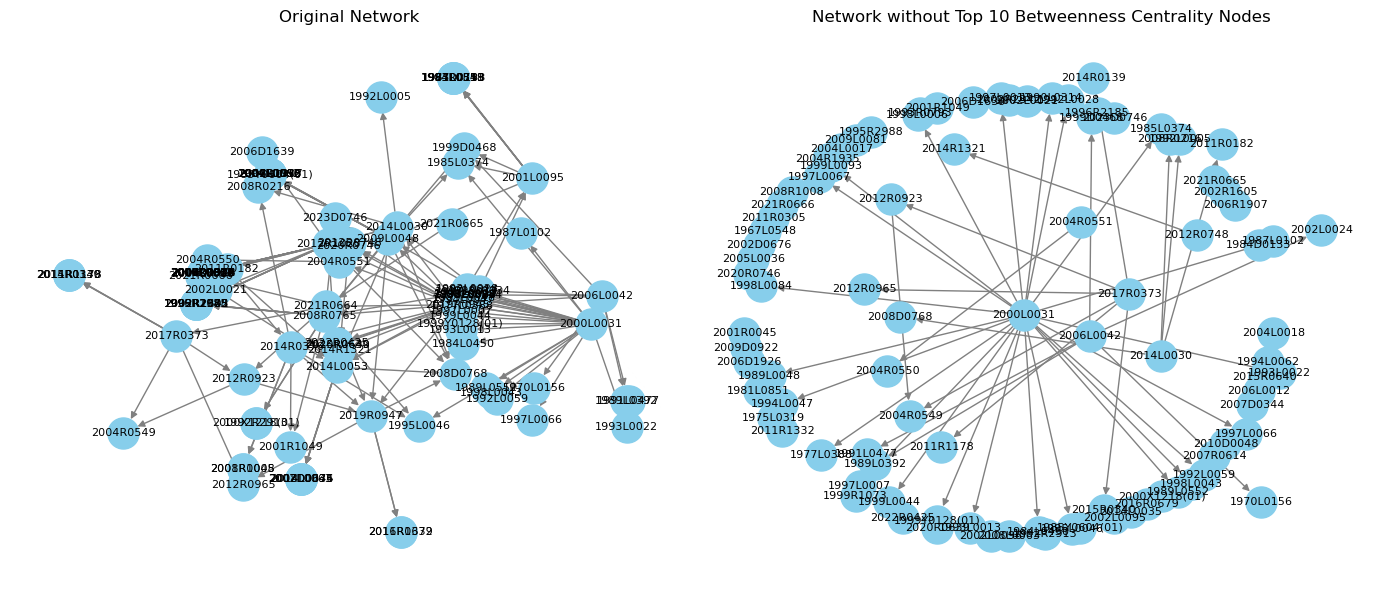

In [402]:
# Function to plot the graph in a specific subplot
def plot_network(ax, graph, title):
    # Get the Kamada-Kawai layout for the graph
    pos = nx.kamada_kawai_layout(graph)
    
    # Draw the network
    nx.draw(graph, pos, with_labels=True, ax=ax, node_color='skyblue', 
            node_size=500, font_size=8, font_color='black', 
            edge_color='gray', linewidths=1.0)
    
    ax.set_title(title)

# 1. Create the original network and filtered network
# Get all nodes for the first visualization
all_nodes = resdf_drones_trimmed.index.tolist()
# Get the top 10 nodes with the highest betweenness centrality
top_10_betweenness_nodes = resdf_drones_trimmed.nlargest(10, 'betweenness_norm').index.tolist()
# Create a filtered version of the graph without the top 10 nodes
g_drones_filtered = g_drones.copy()  # Create a copy of the original graph
g_drones_filtered.remove_nodes_from(top_10_betweenness_nodes)

# 2. Set up side-by-side plotting using subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Plot the original network
plot_network(axs[0], g_drones, title="Original Network")
# Plot the filtered network (without the top 10 betweenness centrality nodes)
plot_network(axs[1], g_drones_filtered, title="Network without Top 10 Betweenness Centrality Nodes")

# Display both plots
plt.tight_layout()
plt.show()

How can betweenness centrality be explained in more mathematical terms? Betweenness centrality focuses on the number of shortest paths that pass through a node $ v $. First take any pair of nodes $ s, t $. We can obtain the length of all the shortest paths between $ s $ and $ t $ using a shortest path function that we here call $ spath $.

$$ spath(s, t) $$

We can also get the length of all the shortest paths between $ s $ and $ t $ that pass through our node of interest, $ v $.

$$ spaths(s, t \mid v) $$ 
(The bar there just says "on condition that they pass through $ v $".)

Subsequently we can calculate the proportion or ratio of shortest paths that pass through $ v $ compared to the total number of shortest paths:

$$ \frac{spaths(s, t \mid v)}{spath(s, t)} $$

This will do it for a pair of nodes $ s, t $. But we need to do this for every pair of nodes $ s, t $, and sum the results:

$$ \sum_{s,t \in V} \frac{spaths(s, t \mid v)}{spath(s, t)} $$

(Remember that the $ \Sigma $ is effectively saying, "do this for every pair of nodes $ s $, $ t $ in $ V $, adding up the results along the way".)

## 3.6 Hyperlink-Induced Topic Search (HITS)

HITS is an algorithm for identifying centrality in directed networks. It produces two scores:

* The authority score keeps track of how effective are nodes in receiving citations or references from other nodes. 

* The hub score keeps track how effective are nodes in making citations to other nodes.

So far this may look like in-degree and out-degree. The key difference is that the HITS algorithm does not merely count neighbors, but like Eigenvector Centrality and PageRank works recursively. A node receives a high hub score by citing  highly ranked authorities and a high authority score by being cited by highly ranked hubs and these scores are updated progressively through various iterations. 

Below we apply the algorithm to the Obergefell network and we can see what one should expect, that Obergefell is the key hub, and that Loving v. Virginia the key authority. NetworkX provides us with the option of returning HITS results normalized or not-normalized. The normalized results are clearly more informative. Normalization here means showing each score as the proportion of the total scores, so that the scores would sum to 1 (or function as a percentage if multiplied by a 100). Appendix 3 provides more insight into normalization.

In [403]:
# here the code will be more verbose because HITS provides two sets of results, 
# and has a normalization option built in.
g_ob = load_graph_from_json("data/obergefell.json")
cases = list(g_ob.nodes)
hits = nx.hits(g_ob, normalized=False)
hits_norm = nx.hits(g_ob, normalized=True)
hubs = list(hits[0].values())
authorities = list(hits[1].values())
hubs_norm = list(hits_norm[0].values())
authorities_norm = list(hits_norm[1].values())


resdf_g_ob = pd.DataFrame({'nodes':cases,
                   'hubs': hubs,
                  'authorities': authorities,
                  'hubs_normalized': hubs_norm,
                   "authorities_normalized": authorities_norm})
resdf_g_ob.set_index("nodes", inplace=True)
resdf_g_ob.to_csv("data/hits_obergefell_results_1.csv")
resdf_g_ob

/opt/anaconda3/envs/netenv2/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


,hubs,authorities,hubs_normalized,authorities_normalized
nodes,,,,
Obergefell_v_Hodges,-2.771,0.000,0.531,0.000
Lawrence_v_Texas,-0.000,-0.312,0.000,0.106
Bowers_v_Hardwick,0.000,-0.312,0.000,0.106
Zablocki_v_Redhail,-0.471,-0.312,0.090,0.106
Turner_v_Safley,-0.471,-0.312,0.090,0.106
Windsor_v_United_States,-0.471,-0.312,0.090,0.106
PPvCasey,-0.483,-0.000,0.093,0.000
Roe_v_Wade,-0.553,-0.054,0.106,0.018
Griswold_v_Connecticut,-0.000,-0.429,0.000,0.145


Like Eigenvector centrality, HITS is an iterative algorithm that can be represented in many ways. Here, we will present one option that uses repeated multiplication on a modified version of the adjacency matrix. For this, let us first get the adjacency matrix of our graph.

Note that because this is a directed network the adjacency matrix is not symmetrical.

In [404]:
Ad = nx.adjacency_matrix(g_ob).todense()
Ad

array([[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Now we have to scale the adjacency matrix by the transpose of itself. Transposition here just swaps the order of rows and columns. We call this new matrix M.

$$ M = Ad^T \times Ad $$

In numpy code this is represented in this manner:

In [405]:
M = Ad.T@Ad
M

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

Unlike the Adjacency matrix for a directed network, this M matrix is symmetrical. This implies that the resulting network is bidirectional or undirected even if the original network was directed. This further implies that there is less reason to worry about a random walker being trapped, and hence no need for the teleportation strategy used in PageRank.

Now that we have M, we are going to simulate the repeated scaling of a set of initial values by M, just like with did with Eigenvector Centrality. Since we have a 16x16 matrix, we are going to create a vector x with 16 initial values of 0.0625.

$$ x = [0.0625, 0.0625, 0.0625, 0.0625 ... ] $$



In order to get the authority score, we repeatedly multiply the new matrix M with the vector of probabilities x like we did before in Eigenvector Centrality and PageRank. After many repetitions, the values of x stabilize giving us the unnormalized authorities results. Here we also divide this score by its total, to get the normalized results.

Here we will present only the normalized results to make the table smaller.

In [406]:
x = (np.ones(16)/16)
for i in range(0,100):
    x = M@x.reshape(16,1)
# this normalization is intented to keep numbers within reasonable bounds
# and make calculations easier
    xnorm = np.linalg.norm(x)
    x = x/xnorm

auth_by_hand = x
auth_by_hand_norm = auth_by_hand/np.sum(auth_by_hand)

resdf_g_ob = resdf_g_ob.drop(["hubs", "authorities"], axis=1)

#resdf_g_ob["auth_by_hand"] = auth_by_hand
resdf_g_ob["auth_by_hand_norm"] = auth_by_hand_norm

resdf_g_ob

,hubs_normalized,authorities_normalized,auth_by_hand_norm
nodes,,,
Obergefell_v_Hodges,0.531,0.000,0.000
Lawrence_v_Texas,0.000,0.106,0.106
Bowers_v_Hardwick,0.000,0.106,0.106
Zablocki_v_Redhail,0.090,0.106,0.106
Turner_v_Safley,0.090,0.106,0.106
Windsor_v_United_States,0.090,0.106,0.106
PPvCasey,0.093,0.000,0.000
Roe_v_Wade,0.106,0.018,0.018
Griswold_v_Connecticut,0.000,0.145,0.145


Now let's get the hubs scores. For these we are going to first get a matrix N that is produced by multiplying the adjacency matrix by itself tranposed (if you think of multiplication in algebra, this procedure may appear identical to the one we used to get the matrix M. Multiplication is normally commutative, that is to say $ 3 \times 4 $ is the same as $ 4 \times 3 $ However matrix multiplication is not commutative and the resulting matrix is different. 

$$ N = Ad \times Ad^T $$

Since we have a 16x16 matrix, we are going to create a vector y with 16 initial values of 0.0625, exactly the same as we did for x above.

$$ x = [0.0625, 0.0625, 0.0625, 0.0625 ... ] $$


In [407]:
Ad = nx.adjacency_matrix(g_ob).todense()
N = Ad@Ad.T
y = (np.ones(16)/16)
for i in range(0,100):
    y = N@y.reshape(16,1)
    ynorm = np.linalg.norm(y)
    y = y/ynorm

hubs_by_hand = y

hubs_by_hand_norm = hubs_by_hand/(np.sum(hubs_by_hand))


#resdf["hubs_by_hand"] = hubs_by_hand
resdf_g_ob["hubs_by_hand_norm"] = hubs_by_hand_norm
resdf_g_ob[['hubs_normalized', "authorities_normalized", "hubs_by_hand_norm","auth_by_hand_norm"]]

,hubs_normalized,authorities_normalized,hubs_by_hand_norm,auth_by_hand_norm
nodes,,,,
Obergefell_v_Hodges,0.531,0.000,0.531,0.000
Lawrence_v_Texas,0.000,0.106,0.000,0.106
Bowers_v_Hardwick,0.000,0.106,0.000,0.106
Zablocki_v_Redhail,0.090,0.106,0.090,0.106
Turner_v_Safley,0.090,0.106,0.090,0.106
Windsor_v_United_States,0.090,0.106,0.090,0.106
PPvCasey,0.093,0.000,0.093,0.000
Roe_v_Wade,0.106,0.018,0.106,0.018
Griswold_v_Connecticut,0.000,0.145,0.000,0.145


Note: if you were to compare unnormalized results they might not match. This is not significant, and it has more to do with the underlying algorithms that produced the results and not with their validity or significance. After normalization, the results converge exactly, showing their equivalence.

Alternatively, if we have the authority scores, we can just scale them by the adjacency matrix to get the hubs scores:

In [408]:
Ad = nx.adjacency_matrix(g_ob).todense()
x = auth_by_hand
alterantive_y = Ad@x
alterantive_y_norm = alterantive_y/(np.sum(alterantive_y))
cases = resdf_g_ob.index

pd.Series(np.ravel(alterantive_y_norm), index=cases)

nodes
Obergefell_v_Hodges                                0.531
Lawrence_v_Texas                                   0.000
Bowers_v_Hardwick                                  0.000
Zablocki_v_Redhail                                 0.090
Turner_v_Safley                                    0.090
Windsor_v_United_States                            0.090
PPvCasey                                           0.093
Roe_v_Wade                                         0.106
Griswold_v_Connecticut                             0.000
Lochner_v_New_York                                 0.000
NAACP_v_State_of_Alabama                           0.000
Union_Pacific_Railroad_v_Botsford                  0.000
Loving_v_Virginia                                  0.000
Baker_v_Nelson                                     0.000
County_of_Sacramento_vs._Lewis                     0.000
Romer_v_Evans                                      0.000
dtype: float64

For yet one more way to calculate the HITS score, remember that repeated multiplication is connected to eigenvectors, so here we can see that an alternative way to get the same result is to get the eigenvectors corresponding to the largest eigenvalue of M. 

After normalization these correspond exactly to our normalized authority score. 

Now if we scale these results by the adjacency matrix of the graph and normalize, we get the normlaized hubs scores. And through a different path end up in the same place.

In [409]:
Ad = nx.adjacency_matrix(g_ob).todense()
M = Ad.T@Ad
vals, vecs = np.linalg.eig(M)
largest_val = np.argmax(vals)
print(largest_val)
corresponding_vector = vecs[:, 2]
corresponding_vector

eigen_authorities_norm = corresponding_vector / np.sum(corresponding_vector)

eigen_hubs = Ad@corresponding_vector

eigen_hubs_norm = eigen_hubs/(np.sum(eigen_hubs))


resdf_g_ob.drop(["auth_by_hand_norm", "hubs_by_hand_norm"], axis=1, inplace=True)

resdf_g_ob['eigen_hubs_norm'] = eigen_hubs_norm
resdf_g_ob['eigen_auth_norm'] = eigen_authorities_norm

resdf_g_ob

2


,hubs_normalized,authorities_normalized,eigen_hubs_norm,eigen_auth_norm
nodes,,,,
Obergefell_v_Hodges,0.531,0.000,0.531+0.000j,0.000+0.000j
Lawrence_v_Texas,0.000,0.106,-0.000+0.000j,0.106+0.000j
Bowers_v_Hardwick,0.000,0.106,0.000+0.000j,0.106+0.000j
Zablocki_v_Redhail,0.090,0.106,0.090+0.000j,0.106+0.000j
Turner_v_Safley,0.090,0.106,0.090+0.000j,0.106+0.000j
Windsor_v_United_States,0.090,0.106,0.090+0.000j,0.106+0.000j
PPvCasey,0.093,0.000,0.093+0.000j,-0.000+0.000j
Roe_v_Wade,0.106,0.018,0.106+0.000j,0.018+0.000j
Griswold_v_Connecticut,0.000,0.145,0.000+0.000j,0.145+0.000j


The advantages and disadvantages of this or that procedure for getting the results will not be discussed here.

Finally, we compare the HITS (authority) scores to the previously obtained scores. The results return nodes that were also returned in some of the previous analyses.

In [410]:
# Calculating HITS centrality (Hubs and Authorities)
hits = nx.hits(g_drones, normalized=False)
hits_norm = nx.hits(g_drones, normalized=True)

# Extracting hubs and authorities (non-normalized and normalized)
hubs = list(hits[0].values())
authorities = list(hits[1].values())
hubs_norm = list(hits_norm[0].values())
authorities_norm = list(hits_norm[1].values())

# Assigning the values to the DataFrame
resdf_drones['hubs'] = hubs  # Storing non-normalized hubs scores
resdf_drones['authorities'] = authorities  # Storing non-normalized authorities scores
resdf_drones['hubs_norm'] = hubs_norm  # Storing normalized hubs scores
resdf_drones['authorities_norm'] = authorities_norm  # Storing normalized authorities scores


# Trimming the DataFrame to relevant columns
resdf_drones_trimmed = resdf_drones[["hubs", "authorities", "hubs_norm", "authorities_norm"]]

# Sorting by HITS normalized scores
resdf_drones_trimmed.sort_values("hubs_norm", ascending=False)

,hubs,authorities,hubs_norm,authorities_norm
nodes,,,,
2012R1025,3.267,0.100,0.205,0.014
2019R0945,2.814,0.053,0.177,0.007
2008R0765,1.540,0.227,0.097,0.031
2000L0031,1.281,0.000,0.080,-0.000
2014L0030,1.204,0.258,0.076,0.035
...,...,...,...,...
1999L0093,0.000,0.046,-0.000,0.006
2004R1935,0.000,0.043,-0.000,0.006
2004L0017,0.000,0.116,-0.000,0.016


## 3.7 Comparing Centrality Scores

To conclude this section, it is worth reflecting on the value of different centrality measures. As has been noted above, there is a significant degree of judgment needed to determine which centrality measure is the best for each case. 

It may be valuable to look at centrality measures together in order to ascertain where things stand. Here we provide a simple analysis that includes the degree of correlation between the measures of degree centrality, pagerank, closeness centrality and betweeness centrality for the drones network.

Text(0.5, 1.0, 'Correlation Centrality - Drones')

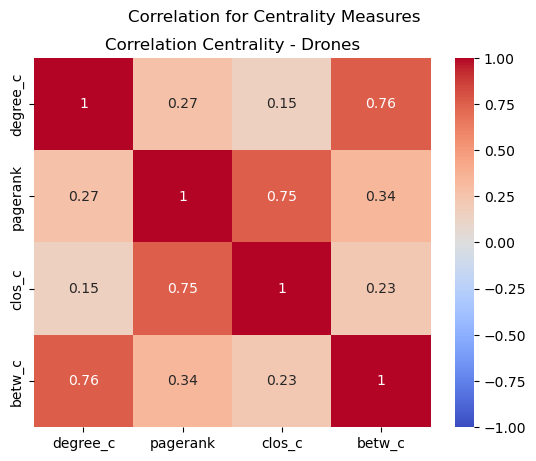

In [411]:

# Centrality Measures for Drones
results_drones = []
for i in [nx.degree_centrality, nx.pagerank, nx.closeness_centrality, nx.betweenness_centrality]:
    res = i(g_drones)
    results_drones.append(res)

comparision_drones = pd.DataFrame({
    "nodes": results_drones[0].keys(), 
    "degree_c": results_drones[0].values(),
    "pagerank": results_drones[1].values(),
    "clos_c": results_drones[2].values(),
    "betw_c": results_drones[3].values()
})
comparision_drones.set_index("nodes", inplace=True)

# Plotting
plt.suptitle("Correlation for Centrality Measures")

sns.heatmap(comparision_drones.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm").set_title("Correlation Centrality - Drones")


Normally one would expect all measures to be positively correlated (being more central in one way, makes one more central in other ways), although not always or to the same intensity. If we nevertheless observe that measures are negatively correlated we learn something important about the graph structure, for example, that the graph is easy to separate as the network brokers have a limited degree of connections.